# library

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import random

2022-06-18 14:34:26.070783: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## mk_cd 함수

In [2]:
## 함수
def mk_cd(x):
    if type(x) == str:
        if x.isalpha():
            return x
        else:
            if len(x) == 6:
                return x
            else:
                return "0"*(6-len(x))+x
    elif type(x) == int:
        x = str(x)
        return "0"*(6-len(x))+x

# 슬라이싱 준비

In [3]:
len_a2012 = 284412
len_a2013 = 242826
len_a2014 = 242448
len_a2015 = 314361
len_a2016 = 263593
len_a2017 = 216591
len_a2018 = 307395
len_a2019 = 278610
len_a2020 = 371006
len_a2021 = 321808

In [4]:
len1215 = len_a2012+len_a2013+len_a2014+len_a2015 # y:2015
len1316 = len1215+len_a2016 # y:2016
len1417 = len1316+len_a2017 # y:2017
len1518 = len1417+len_a2018 # y:2018
len1619 = len1518+len_a2019 # y:2019
len1720 = len1619+len_a2020 # y:2020
len1821 = len1720+len_a2021 # y:2021

## [0], [1]은 train 슬라이싱 인덱스, [2]는 test인덱스로 구성

In [5]:
slicing_dic = {'1215':[0, len1215, len_a2015],
               '1316':[len_a2012, len1316, len_a2016],
               '1417':[len_a2012+len_a2013, len1417, len_a2017],
               '1518':[len_a2012+len_a2013+len_a2014, len1518, len_a2018],
               '1619':[len_a2012+len_a2013+len_a2014+len_a2015, len1619, len_a2019],
               '1720':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016,len1720, len_a2020],
               '1821':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016+len_a2017,len1821, len_a2021]}

## 슬라이싱 테스트

In [6]:
# d1221[:len1215]
# d1221[len_a2012:len1316]
# d1221[len_a2012+len_a2013:len1417]
# d1221[len_a2012+len_a2013+len_a2014:len1518]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015:len1619]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016:len1720]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016+len_a2017:len1821]

# data load

In [6]:
d1221 = pd.read_feather('d1221.ftr', columns = None, use_threads = True) # threads 사용을 꺼도 난리 (그래도 비교적 덜 난리)

# category to object

In [7]:
d1221['code'] = list(map(mk_cd, d1221['code'])) # mk_cd함수 적용시켜야 ftr만들 때 에러 안남.

In [8]:
d1221.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843050 entries, 0 to 2843049
Columns: 823 entries, date to NextChange
dtypes: float64(821), int64(1), object(1)
memory usage: 17.4+ GB


# modeling

In [9]:
# NextChange
d1221['NextChange'] = np.where(d1221['NextChange']>0.05, 1, 0)

In [13]:
cnt0 = d1221.shape[0] - d1221['NextChange'].sum()
cnt1 = d1221['NextChange'].sum()
cnt1
cnt0-cnt1
(cnt0-cnt1) / d1221.shape[0]
d1221.shape[0]

1297139

248772

0.08750180264152935

2843050

In [10]:
from datetime import datetime
# 1. Logistic regression
from sklearn.linear_model import LogisticRegression
# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
# 3. Support vector machine
from sklearn.svm import SVC
# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
# 8. Neural network
from sklearn.neural_network import MLPClassifier
# import lightgbm as lgb
from xgboost import XGBClassifier # decision tree 앙상블 모델, 부스팅
# [light gbm 장점, 하이퍼파라미터 튜닝 방안](https://ariz1623.tistory.com/209)
# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
# [XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)


from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

# 모델 평가 지표 scoring metrics
from sklearn.model_selection import cross_val_score # model 검증

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

import ast # convert string to function

# [scikit-learn classifier metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)
# [classification metrics 1](https://hong-yp-ml-records.tistory.com/29)
# [classification metrics 2](https://sw-data.tistory.com/23) -> regression metrics 참고

results = []
def my_classifier():
    
    # X, y
    X = d1221.iloc[:,2:-1] # 1221 데이터
    y = d1221.iloc[:,-1]
    
    # seed 고정
    user_seed = 0
    random.seed(user_seed) # seed 고정
    
    # 모델
    # (같은 줄에 써놓은 애들끼리 하이퍼파리미터 구성 비슷하거나 같음)
#     Logistic_Regression = LogisticRegression(n_jobs=64,
#                                              random_state=user_seed,
#                                              max_iter=10) # , verbose = 1
    # [모델훈련](https://taek98.tistory.com/15)

    DecisionTree = DecisionTreeClassifier(max_depth = 10,
                                          random_state=user_seed,
                                          max_leaf_nodes=4)
    
    RandomForest = RandomForestClassifier(n_estimators=10,
                                          max_depth=10,
                                          random_state=user_seed,
                                          max_leaf_nodes=4,
                                          n_jobs=64) # , verbose=1
    
    GradientBoosting = GradientBoostingClassifier(n_estimators=10,
                                                  max_depth = 10,
                                                  random_state = user_seed,
                                                  max_leaf_nodes=4,
                                                  learning_rate=0.05) # , verbose = 1
    
#     SVM = SVC(max_iter=1000,
#               random_state=user_seed) # , verbose=True
    
#     Gaussian_NB = GaussianNB()
    KNeighbors = KNeighborsClassifier(n_jobs = 64)
    MLP = MLPClassifier(max_iter=1000,
                        batch_size = 10000,
                        shuffle=True,
                        random_state = user_seed,
                        early_stopping=True) # early_stopping 있어서 max_iter 키움., verbose=True

#     XGBoost = XGBClassifier(n_jobs=64,
#                             max_depth=10,
#                             n_estimators=10,
#                             learning_rate=0.05,
#                             random_state = user_seed) # early_stopping_rounds = 50,
    # [XGBoost Classifier hyper params](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
#     LGBM = lgb.LGBMClassifier(num_leaves=15,
#                               learning_rate=0.05,
#                               n_estimators=10,
#                               max_depth = 10,
#                               random_state = user_seed) # early_stopping_rounds, best_iteration_,
    # max_depth : 과적합 방지를 위해 깊이 크기 제한
    # n_estimators : 너무 크면 과적합, 성능저하
    # learning_rate 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다.
    # [LGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
    
    # [gbm grid CV, best_iteration_ 참고](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py)
    # [how to save model to best iteration if early stopping does not happen?](https://github.com/Microsoft/LightGBM/issues/1683)
    
    dummy = DummyClassifier(strategy = 'stratified', random_state = user_seed) # strategy 옵션: 'stratified', 'uniform', 'most_frequent'
    
    my_model_list = ['MLP',
                     'DecisionTree', 'RandomForest', 'GradientBoosting','KNeighbors'] # 오래 걸리는걸 앞으로 뺌
    # 'LGBM', 서버 자꾸 터져서 뺍니다
    # 'XGBoost', 'dummy', 'Logistic_Regression', 'SVM', 'Gaussian_NB', 끝나서 뺍니다.
    
    i = 0
    
    ######################################################################### fitting
    for model_nm in tqdm(my_model_list):
        print(f'<<<---{model_nm} start--->>>')
        print(datetime.now().strftime('%H:%M:%S'))
        cntcnt = 0
        # cv # 년도 나눠지는 것에 따라서 개수 정함.
        for slicer in slicing_dic:
            print(f'<<<---{slicer} start--->>>')
            print(datetime.now().strftime('%H:%M:%S'))
            tmpX = X[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # X를 연속 4년치 꺼내서 reset_index(drop = True)
            tmpy = y[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # y를 연속 4년치 꺼내서 reset_index(drop = True)
#             tmp_all = d1221[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # 전체데이터

            X_train = tmpX[:-slicing_dic[slicer][2]] # 기준년도 앞
            X_test = tmpX[-slicing_dic[slicer][2]:] # 기준년도 이하
            y_train = tmpy[:-slicing_dic[slicer][2]] # 기준년도 앞
            y_test = tmpy[-slicing_dic[slicer][2]:] # 기준년도 이하
            
            # train끼리 idx 같아야 하므로
            len_train = slicing_dic[slicer][1]-(slicing_dic[slicer][2]+slicing_dic[slicer][0]) # 혹은 tmp_train.shape[0]
            len(list(range(len_train)))
            train_idx = list(range(len_train))
            random.shuffle(train_idx) # 자동으로 덮어쓰기
            
            # test끼리 idx 같아야 하므로
            len_train_to_test = slicing_dic[slicer][1]-slicing_dic[slicer][0]
            test_idx = list(range(len_train,len_train_to_test)) # +1 안해줘도 되는 거 위 cell에서 확인
            len(test_idx)
            random.shuffle(test_idx) # 자동으로 덮어쓰기
            
            X_train = X_train.loc[train_idx]
            y_train = y_train.loc[train_idx]
            X_test = X_test.loc[test_idx]
            y_test = y_test.loc[test_idx]
            ###########################################
            y_train = np.array(y_train).reshape(-1,1) # 1열짜리로 만드는 것
            y_test = np.array(y_test).reshape(-1,1)

            ######################################################## cv를 위한 데이터 slicing 작업 끝

            # fitting은 cv 안에 넣기
            if model_nm == 'LGBM':
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='auc',
                                            early_stopping_rounds=5) # map: mean average precision
                # eval_metric = logloss, auc, error
                y_pred_test = model_.predict(X_test, num_iteration=LGBM.best_iteration_) # 예측
            # If early stopping occurs, the model will have three additional fields: best_score, best_iteration and best_ntree_limit
            # [eval_metric](https://stats.stackexchange.com/questions/493981/xgboost-mean-average-precision-eval-metric-for-classification)
            # [gbm.fit verbose = 10, #verbose = 10 : 10번 반복할 때마다 logloss값을 보여준다.](https://dacon.io/codeshare/1827)
            # [Classifier, Regressor eval_metric 예시](https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost)
            # [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#)
            # error: For MAP metric, there should be query information
            elif model_nm == 'XGBoost': # xgboost_linear가 느려서
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='auc',
                                            early_stopping_rounds=5) # ,verbose = True
                y_pred_test = model_.predict(X_test) # 예측
            
            else:
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train)
                y_pred_test = model_.predict(X_test) # 예측

            accuracy = accuracy_score(y_test, y_pred_test)
            roc_auc = roc_auc_score(y_test, y_pred_test)
            f1 = f1_score(y_test, y_pred_test)
            jaccard = jaccard_score(y_test, y_pred_test)
#             cv_scores = cross_val_score(eval(model_nm), tmpX, tmpy, cv=7, n_jobs = 64)
            
            _ = dummy.fit(X_train, y_train)
            dummy_score = dummy.score(X_test, y_test)

            results.append([i, f'{model_nm}', accuracy, roc_auc, f1, jaccard, dummy_score]) # , cv_scores
            i+=1
        ################################################################
        print(results[-7:])
    return results#score_dic#[0]

In [ ]:
import time
start = time.time()
_ = my_classifier()
results
time.time()-start

# local variable 변수명 referenced before assignment
# 함수 밖에서 설정한 변수를 함수 안에서 쓰려고 할 때 발생하는 에러

# logistic regression : 총 22분 걸림 (텀 당 3분 ~ 3분 30초 정도)
# 'SVM' : 한 타임에 40분씩 걸림.( 총 280분 (6시간 40분))
# 'Gaussian_NB' : 3m
# 'KNeighbors' : 1term 3h 25m --> 1h 30m (cv_score 제외 한 후)
# -------------------------------------
# 'MLP' : 텀 하나에 2~3분, 총 17분.
# 'DecisionTree' : 텀 하나에 5분, 총 32분 걸림.
# 'RandomForest' : 텀 하나에 14초..? 이거 왜 빠름..? 1분 30초 걸림.
# 'GradientBoosting' : 텀 하나에 50분.

### cv_scores가 빠져서 그런가 tree기반이 빨라짐. 고로 튜닝 좀더 깊게 해도 될 것 같음.

# --------------------------------------
# 'XGBoost' : 텀 하나에 8분 (총 1시간 걸림.)
# 'LGBM' : # LGBM은 포기;;;
# 'dummy' : 1분

  0%|                                                     | 0/5 [00:00<?, ?it/s]

<<<---MLP start--->>>
14:48:28
<<<---1215 start--->>>
14:48:28
$$$$$---1
<<<---1316 start--->>>
14:50:06
$$$$$---2
<<<---1417 start--->>>
14:53:03
$$$$$---3
<<<---1518 start--->>>
14:56:02
$$$$$---4
<<<---1619 start--->>>
14:57:35
$$$$$---5
<<<---1720 start--->>>
15:01:35
$$$$$---6
<<<---1821 start--->>>
15:03:24
$$$$$---7


 20%|████████▏                                | 1/5 [16:59<1:07:59, 1019.98s/it]

[[0, 'MLP', 0.5152102200972767, 0.49761857430182693, 0.34155530496472286, 0.2059491679084647, 0.5057084053047293], [1, 'MLP', 0.5201845269032183, 0.5002333308412108, 0.3265675583574715, 0.1951483371727482, 0.5022553709696388], [2, 'MLP', 0.5439007160962367, 0.5006503630676291, 0.18860113840770767, 0.1041190553923169, 0.5052749190871274], [3, 'MLP', 0.5158476878283642, 0.5005430810842111, 0.3908662268135754, 0.24290474373648735, 0.5037980448608468], [4, 'MLP', 0.5307275402892933, 0.49832344494313824, 0.19476744186046513, 0.10789049919484701, 0.5045655216969958], [5, 'MLP', 0.5126817356053541, 0.5055070517253918, 0.40456461599262283, 0.2535763090426432, 0.5020242260232988], [6, 'MLP', 0.5292255009198031, 0.5016852276472746, 0.2730757973427506, 0.15812842099413743, 0.502433127827773]]
<<<---DecisionTree start--->>>
15:05:28
<<<---1215 start--->>>
15:05:28
$$$$$---1
<<<---1316 start--->>>
15:10:18
$$$$$---2
<<<---1417 start--->>>
15:14:54
$$$$$---3
<<<---1518 start--->>>
15:19:40
$$$$$---4

 40%|████████████████▍                        | 2/5 [49:13<1:17:52, 1557.48s/it]

[[7, 'DecisionTree', 0.543082634296239, 0.5181294685684631, 0.2867258922319828, 0.1673555276017785, 0.5038061337125153], [8, 'DecisionTree', 0.5407730857799714, 0.5156496952707778, 0.29042223303418074, 0.1698795098099725, 0.5051841285618358], [9, 'DecisionTree', 0.5514218042300927, 0.518265283120038, 0.3088676748851172, 0.18263956657805297, 0.5043884556606691], [10, 'DecisionTree', 0.5502984759023406, 0.5193972236888679, 0.29056627013045666, 0.16997808400132097, 0.503863107727842], [11, 'DecisionTree', 0.5445174257923262, 0.5022794876340585, 0.02865759380310151, 0.014537095997639275, 0.5030652166110333], [12, 'DecisionTree', 0.5325870740634923, 0.5176533063359036, 0.27669540481582977, 0.16056093948165862, 0.5015606216611053], [13, 'DecisionTree', 0.5453717744742207, 0.5098813605016836, 0.18546335216991902, 0.10220975828275825, 0.503228633222294]]
<<<---RandomForest start--->>>
15:37:42
<<<---1215 start--->>>
15:37:42
$$$$$---1
<<<---1316 start--->>>
15:37:56
$$$$$---2
<<<---1417 start-

 60%|██████████████████████████▍                 | 3/5 [50:58<29:48, 894.19s/it]

[[14, 'RandomForest', 0.5391285814716202, 0.5, 0.0, 0.0, 0.5040669803188055], [15, 'RandomForest', 0.5439446419290346, 0.5068852062322965, 0.08797578314075671, 0.04601185610780011, 0.50262715625984], [16, 'RandomForest', 0.5603741614379175, 0.510242172249833, 0.1214419501573154, 0.06464636542239685, 0.5042961157204131], [17, 'RandomForest', 0.5575041884220628, 0.5178050335273706, 0.1870461459385478, 0.1031720391114862, 0.5047804941524748], [18, 'RandomForest', 0.5474426617852912, 0.5084189321166515, 0.10471828735754607, 0.055252096117967046, 0.5044506658052474], [19, 'RandomForest', 0.5212449394349418, 0.5015962547843912, 0.11772244326225281, 0.06254255268616306, 0.5027196325665892], [20, 'RandomForest', 0.5428982498881321, 0.49942829413000756, 0.027451058174821984, 0.013916540975364504, 0.50320998856461]]
<<<---GradientBoosting start--->>>
15:39:27
<<<---1215 start--->>>
15:39:27
$$$$$---1
<<<---1316 start--->>>
16:27:17
$$$$$---2
<<<---1417 start--->>>
17:14:40
$$$$$---3
<<<---1518 s

 80%|███████████████████████████████▏       | 4/5 [6:11:44<2:15:39, 8139.42s/it]

[[21, 'GradientBoosting', 0.5391285814716202, 0.5, 0.0, 0.0, 0.504531414520249], [22, 'GradientBoosting', 0.5403671569427109, 0.5, 0.0, 0.0, 0.503218977742201], [23, 'GradientBoosting', 0.5567498187828672, 0.5, 0.0, 0.0, 0.5029664205807259], [24, 'GradientBoosting', 0.5494266334846045, 0.5019321974697658, 0.03383233115225247, 0.017207246201988234, 0.5024382309406464], [25, 'GradientBoosting', 0.5442410538028067, 0.501804594410495, 0.023381198132580622, 0.011828885827905276, 0.5029934316786906], [26, 'GradientBoosting', 0.5242934076537846, 0.5027626880594303, 0.05038363446576345, 0.025842845472810367, 0.5031886276771804], [27, 'GradientBoosting', 0.5441536568388604, 0.499768369220582, 0.008502700181814496, 0.004269501235372376, 0.504042783274499]]
<<<---KNeighbors start--->>>
21:00:13
<<<---1215 start--->>>
21:00:13
$$$$$---1
<<<---1316 start--->>>
22:31:32
$$$$$---2
<<<---1417 start--->>>
23:54:31
$$$$$---3


In [ ]:
import time
start = time.time()
_ = my_classifier()
results
time.time()-start

# local variable 변수명 referenced before assignment
# 함수 밖에서 설정한 변수를 함수 안에서 쓰려고 할 때 발생하는 에러

# logistic regression : 총 22분 걸림 (텀 당 3분 ~ 3분 30초 정도)
# 'SVM' : 한 타임에 40분씩 걸림.( 총 280분 (6시간 40분))
# 'Gaussian_NB' : 3m
# 'KNeighbors' : 1term 3h 25m
# 'MLP' : 
# 'DecisionTree' : 
# 'RandomForest' : 
# 'GradientBoosting' : 
# 'XGBoost' : 텀 하나에 8분 (총 1시간 걸림.)
# 'LGBM' : # LGBM은 포기;;;
# 'dummy' : 1분

  0%|                                                    | 0/10 [00:00<?, ?it/s]

<<<---XGBoost start--->>>
13:07:09
<<<---1215 start--->>>
13:07:09
$$$$$---1
[0]	validation_0-auc:0.54430
[1]	validation_0-auc:0.54672
[2]	validation_0-auc:0.54949
[3]	validation_0-auc:0.55033
[4]	validation_0-auc:0.55229
[5]	validation_0-auc:0.55346
[6]	validation_0-auc:0.55434
[7]	validation_0-auc:0.55481
[8]	validation_0-auc:0.55506
[9]	validation_0-auc:0.55551
<<<---1316 start--->>>
13:15:25
$$$$$---2
[0]	validation_0-auc:0.54311
[1]	validation_0-auc:0.54671
[2]	validation_0-auc:0.54980
[3]	validation_0-auc:0.55129
[4]	validation_0-auc:0.55332
[5]	validation_0-auc:0.55411
[6]	validation_0-auc:0.55497
[7]	validation_0-auc:0.55600
[8]	validation_0-auc:0.55670
[9]	validation_0-auc:0.55734
<<<---1417 start--->>>
13:23:53
$$$$$---3
[0]	validation_0-auc:0.54180
[1]	validation_0-auc:0.54673
[2]	validation_0-auc:0.54873
[3]	validation_0-auc:0.55027
[4]	validation_0-auc:0.55182
[5]	validation_0-auc:0.55321
[6]	validation_0-auc:0.55405
[7]	validation_0-auc:0.55517
[8]	validation_0-auc:0.5559

 10%|███▊                                  | 1/10 [1:00:06<9:00:58, 3606.45s/it]

[[0, 'XGBoost', 0.5521772738984798, 0.5239100157990049, 0.2508700418258639, 0.14342561606327958, array([0.56581258, 0.56403683, 0.56650351, 0.5674269 , 0.56070488,
       0.56339756, 0.56163189]), 0.5057084053047293], [1, 'XGBoost', 0.554286342960549, 0.5265651410217371, 0.27422951710845755, 0.1589026581616947, array([0.5649944 , 0.56230825, 0.55958259, 0.56277569, 0.56259135,
       0.56688108, 0.56562358]), 0.5022553709696388], [2, 'XGBoost', 0.5647049046359267, 0.5277673094679406, 0.2918071945256105, 0.17082801987599489, array([0.56005724, 0.56075252, 0.56343238, 0.56495795, 0.56894061,
       0.56615275, 0.55919698]), 0.5052749190871274], [3, 'XGBoost', 0.5546316628442233, 0.5247926666951376, 0.30864247406853784, 0.18248210052369776, array([0.56066573, 0.5612311 , 0.56311142, 0.56321306, 0.55555838,
       0.57119807, 0.5695782 ]), 0.5037980448608468], [4, 'XGBoost', 0.5541617314525681, 0.5225999440473098, 0.24485230194965074, 0.1395052406254113, array([0.56161982, 0.56300513, 0.55

 20%|███████▌                              | 2/10 [1:01:26<3:24:15, 1531.97s/it]

[[7, 'dummy', 0.5038061337125153, 0.499840406552872, 0.4548568153382681, 0.29437842385969354, array([0.5035967 , 0.50280892, 0.50165952, 0.5059859 , 0.50803931,
       0.50574698, 0.50583419]), 0.5038061337125153], [8, 'dummy', 0.5051841285618358, 0.5015875227581409, 0.4591916276909809, 0.2980199458566331, array([0.50164593, 0.50421358, 0.50352229, 0.50283758, 0.50425966,
       0.50492794, 0.5037297 ]), 0.5051841285618358], [9, 'dummy', 0.5043884556606691, 0.49978233216229484, 0.4509628417256988, 0.29112461203196194, array([0.50527872, 0.5025246 , 0.50375316, 0.5036384 , 0.50292287,
       0.50521797, 0.50335154]), 0.5043884556606691], [10, 'dummy', 0.503863107727842, 0.49956329219324225, 0.45309082041756016, 0.2929007251349196, array([0.50556473, 0.50176598, 0.50451023, 0.50301105, 0.50381146,
       0.50396392, 0.50395757]), 0.503863107727842], [11, 'dummy', 0.5030652166110333, 0.4989752389149613, 0.45365470595431173, 0.2933721903517547, array([0.50266228, 0.5048814 , 0.50526219, 0.

/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[13:08:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

<<<---1417 start--->>>
14:15:01
$$$$$---3
<<<---1518 start--->>>
14:18:08
$$$$$---4


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i

<<<---1619 start--->>>
14:21:13
$$$$$---5
<<<---1720 start--->>>
14:24:08
$$$$$---6


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

<<<---1821 start--->>>
14:27:19
$$$$$---7


 30%|███████████▍                          | 3/10 [1:23:31<2:47:43, 1437.63s/it]

[[14, 'Logistic_Regression', 0.5176564522952911, 0.4944264227012528, 0.27408776246876226, 0.15880747381501864, array([0.54752557, 0.52997469, 0.52942582, 0.52536419, 0.52675896,
       0.52233573, 0.52437961]), 0.5040669803188055], [15, 'Logistic_Regression', 0.5403671569427109, 0.5, 0.0, 0.0, array([0.52321417, 0.54447956, 0.54447297, 0.54447297, 0.54447297,
       0.54447656, 0.54447656]), 0.50262715625984], [16, 'Logistic_Regression', 0.5532455180501499, 0.5008853542075404, 0.07278720570338926, 0.03776812084207595, array([0.53795007, 0.53948239, 0.54068394, 0.54071769, 0.54075144,
       0.54154122, 0.54328646]), 0.5042961157204131], [17, 'Logistic_Regression', 0.5464142227427251, 0.5001071932728932, 0.052347551858195354, 0.02687725518386946, array([0.54101766, 0.54324736, 0.54215475, 0.54156397, 0.54541354,
       0.54310126, 0.54352687]), 0.5047804941524748], [18, 'Logistic_Regression', 0.5416603854850867, 0.49945848872943505, 0.02393946342581977, 0.012114741923505385, array([0.54

/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

<<<---1316 start--->>>
15:09:05
$$$$$---2


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1417 start--->>>
15:46:53
$$$$$---3


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1518 start--->>>
16:23:48
$$$$$---4


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1619 start--->>>
17:02:53
$$$$$---5


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1720 start--->>>
17:40:29
$$$$$---6


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1821 start--->>>
18:22:37
$$$$$---7


/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

[[21, 'SVM', 0.4608841427530769, 0.5000062902964115, 0.63094193351698, 0.4608584171581633, array([0.4530685 , 0.45270689, 0.45259712, 0.45259066, 0.45246797,
       0.45253254, 0.45251609]), 0.504531414520249], [22, 'SVM', 0.4596328430572891, 0.5, 0.6297924101167254, 0.4596328430572891, array([0.45592205, 0.45567845, 0.45556653, 0.45553361, 0.45556653,
       0.45552344, 0.45552344]), 0.503218977742201], [23, 'SVM', 0.4434717970737473, 0.5000535690916323, 0.6139948058269526, 0.4429960352300768, array([0.45588692, 0.45560341, 0.4553469 , 0.45517814, 0.45484063,
       0.45494188, 0.4548302 ]), 0.5029664205807259], [24, 'SVM', 0.4512955643390426, 0.5001083295635848, 0.6212842776022687, 0.45062536642564005, array([0.45517723, 0.45504383, 0.45449117, 0.4548342 , 0.45452928,
       0.45485961, 0.4544467 ]), 0.5024382309406464], [25, 'SVM', 0.4570044147733391, 0.5001586354834922, 0.6267596946655285, 0.4564093350820143, array([0.45338218, 0.45356601, 0.45338218, 0.45367106, 0.45344127,
      

 50%|███████████████████                   | 5/10 [6:04:04<6:42:29, 4830.00s/it]

[[28, 'Gaussian_NB', 0.4608777806407283, 0.5000033956225882, 0.6309488294511016, 0.4608657755269537, array([0.45300393, 0.45282312, 0.45261003, 0.45266815, 0.45251317,
       0.45251963, 0.45249672]), 0.5045886735313859], [29, 'Gaussian_NB', 0.4596480179670932, 0.5000115749478611, 0.6297912600035869, 0.459631617884174, array([0.45605372, 0.45582329, 0.45565212, 0.45554678, 0.45554019,
       0.45552344, 0.45553661]), 0.5031582781029845], [30, 'Gaussian_NB', 0.443924262781002, 0.49983455433994955, 0.6127261677765381, 0.44167644018375757, array([0.45583292, 0.45566416, 0.45522539, 0.45511064, 0.45499588,
       0.45504313, 0.45510696]), 0.504111435839901], [31, 'Gaussian_NB', 0.45126628604889474, 0.49998634352508403, 0.6210198524323499, 0.4503472029874772, array([0.455209  , 0.45537416, 0.4544467 , 0.45504383, 0.45466904,
       0.45490408, 0.45450387]), 0.5030498218904016], [32, 'Gaussian_NB', 0.456975700800402, 0.500142235900983, 0.6267767893705936, 0.4564274653377837, array([0.4534215

/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/package/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solve

<<<---1316 start--->>>
22:36:06
$$$$$---2
<<<---1417 start--->>>
01:40:33
$$$$$---3
<<<---1518 start--->>>
04:28:21
$$$$$---4


In [ ]:
from datetime import datetime
print(datetime.now().strftime('%H:%M:%S'))
print(f'<<<---{model_nm} start, {datetime.now().strftime('%H:%M:%S')}--->>>')

In [10]:
results = [[0, 'XGBoost', 0.5521772738984798, 0.5239100157990049, 0.2508700418258639, 0.14342561606327958, 0.5057084053047293],
           [1, 'XGBoost', 0.554286342960549, 0.5265651410217371, 0.27422951710845755, 0.1589026581616947, 0.5022553709696388],
           [2, 'XGBoost', 0.5647049046359267, 0.5277673094679406, 0.2918071945256105, 0.17082801987599489, 0.5052749190871274],
           [3, 'XGBoost', 0.5546316628442233, 0.5247926666951376, 0.30864247406853784, 0.18248210052369776, 0.5037980448608468],
           [4, 'XGBoost', 0.5541617314525681, 0.5225999440473098, 0.24485230194965074, 0.1395052406254113, 0.5045655216969958],
           [5, 'XGBoost', 0.5308027363438866, 0.5145795247160921, 0.2405734254141236, 0.13673399554667315, 0.5020242260232988],
           [6, 'XGBoost', 0.5514033212350221, 0.5162459698921552, 0.20077728812808643, 0.11159112588079634, 0.502433127827773],
           [7, 'dummy', 0.5038061337125153, 0.499840406552872, 0.4548568153382681, 0.29437842385969354, 0.5038061337125153],
           [8, 'dummy', 0.5051841285618358, 0.5015875227581409, 0.4591916276909809, 0.2980199458566331, 0.5051841285618358],
           [9, 'dummy', 0.5043884556606691, 0.49978233216229484, 0.4509628417256988, 0.29112461203196194, 0.5043884556606691],
           [10, 'dummy', 0.503863107727842, 0.49956329219324225, 0.45309082041756016, 0.2929007251349196, 0.503863107727842],
           [11, 'dummy', 0.5030652166110333, 0.4989752389149613, 0.45365470595431173, 0.2933721903517547, 0.5030652166110333],
           [12, 'dummy', 0.5015606216611053, 0.4993393207010469, 0.46305458768873403, 0.30128239036960347, 0.5015606216611053],
           [13, 'dummy', 0.503228633222294, 0.49994258337227704, 0.4591682426054921, 0.2980002459073983, 0.503228633222294],
           [14, 'Logistic_Regression', 0.5176564522952911, 0.4944264227012528, 0.27408776246876226, 0.15880747381501864, 0.5040669803188055],
           [15, 'Logistic_Regression', 0.5403671569427109, 0.5, 0.0, 0.0, 0.50262715625984],
           [16, 'Logistic_Regression', 0.5532455180501499, 0.5008853542075404, 0.07278720570338926, 0.03776812084207595, 0.5042961157204131],
           [17, 'Logistic_Regression', 0.5464142227427251, 0.5001071932728932, 0.052347551858195354, 0.02687725518386946, 0.5047804941524748],
           [18, 'Logistic_Regression', 0.5416603854850867, 0.49945848872943505, 0.02393946342581977, 0.012114741923505385, 0.5044506658052474],
           [19, 'Logistic_Regression', 0.5218028818940934, 0.49970645269740815, 0.02122893932539639, 0.010728345359042702, 0.5027196325665892],
           [20, 'Logistic_Regression', 0.5436751106249689, 0.4997439250246456, 0.018290604004412205, 0.00922971049204882, 0.50320998856461],
           [21, 'SVM', 0.4608841427530769, 0.5000062902964115, 0.63094193351698, 0.4608584171581633, 0.504531414520249],
           [22, 'SVM', 0.4596328430572891, 0.5, 0.6297924101167254, 0.4596328430572891, 0.503218977742201],
           [23, 'SVM', 0.4434717970737473, 0.5000535690916323, 0.6139948058269526, 0.4429960352300768, 0.5029664205807259],
           [24, 'SVM', 0.4512955643390426, 0.5001083295635848, 0.6212842776022687, 0.45062536642564005, 0.5024382309406464],
           [25, 'SVM', 0.4570044147733391, 0.5001586354834922, 0.6267596946655285, 0.4564093350820143, 0.5029934316786906],
           [26, 'SVM', 0.47775507673730344, 0.5002212485332145, 0.6457946385480497, 0.47688087562704856, 0.5031886276771804],
           [27, 'SVM', 0.45577176453040324, 0.500258594839805, 0.6251340435232096, 0.45468726647735763, 0.504042783274499],
           [28, 'Gaussian_NB', 0.4608777806407283, 0.5000033956225882, 0.6309488294511016, 0.4608657755269537, 0.5045886735313859],
           [29, 'Gaussian_NB', 0.4596480179670932, 0.5000115749478611, 0.6297912600035869, 0.459631617884174, 0.5031582781029845],
           [30, 'Gaussian_NB', 0.443924262781002, 0.49983455433994955, 0.6127261677765381, 0.44167644018375757, 0.504111435839901],
           [31, 'Gaussian_NB', 0.45126628604889474, 0.49998634352508403, 0.6210198524323499, 0.4503472029874772, 0.5030498218904016],
           [32, 'Gaussian_NB', 0.456975700800402, 0.500142235900983, 0.6267767893705936, 0.4564274653377837, 0.5043286314202649],
           [33, 'Gaussian_NB', 0.47804617715077385, 0.5004094175350301, 0.6454424279708807, 0.4764968586783741, 0.502412359907926],
           [34, 'Gaussian_NB', 0.45682518768955405, 0.5004778353122427, 0.6234392368740791, 0.45289627132649135, 0.5039619897578681],
           [0, 'MLP', 0.5152102200972767, 0.49761857430182693, 0.34155530496472286, 0.2059491679084647, 0.5057084053047293],
           [1, 'MLP', 0.5201845269032183, 0.5002333308412108, 0.3265675583574715, 0.1951483371727482, 0.5022553709696388],
           [2, 'MLP', 0.5439007160962367, 0.5006503630676291, 0.18860113840770767, 0.1041190553923169, 0.5052749190871274],
           [3, 'MLP', 0.5158476878283642, 0.5005430810842111, 0.3908662268135754, 0.24290474373648735, 0.5037980448608468],
           [4, 'MLP', 0.5307275402892933, 0.49832344494313824, 0.19476744186046513, 0.10789049919484701, 0.5045655216969958],
           [5, 'MLP', 0.5126817356053541, 0.5055070517253918, 0.40456461599262283, 0.2535763090426432, 0.5020242260232988],
           [6, 'MLP', 0.5292255009198031, 0.5016852276472746, 0.2730757973427506, 0.15812842099413743, 0.502433127827773],
           [7, 'DecisionTree', 0.543082634296239, 0.5181294685684631, 0.2867258922319828, 0.1673555276017785, 0.5038061337125153],
           [8, 'DecisionTree', 0.5407730857799714, 0.5156496952707778, 0.29042223303418074, 0.1698795098099725, 0.5051841285618358],
           [9, 'DecisionTree', 0.5514218042300927, 0.518265283120038, 0.3088676748851172, 0.18263956657805297, 0.5043884556606691],
           [10, 'DecisionTree', 0.5502984759023406, 0.5193972236888679, 0.29056627013045666, 0.16997808400132097, 0.503863107727842],
           [11, 'DecisionTree', 0.5445174257923262, 0.5022794876340585, 0.02865759380310151, 0.014537095997639275, 0.5030652166110333],
           [12, 'DecisionTree', 0.5325870740634923, 0.5176533063359036, 0.27669540481582977, 0.16056093948165862, 0.5015606216611053],
           [13, 'DecisionTree', 0.5453717744742207, 0.5098813605016836, 0.18546335216991902, 0.10220975828275825, 0.503228633222294],
           [14, 'RandomForest', 0.5391285814716202, 0.5, 0.0, 0.0, 0.5040669803188055],
           [15, 'RandomForest', 0.5439446419290346, 0.5068852062322965, 0.08797578314075671, 0.04601185610780011, 0.50262715625984],
           [16, 'RandomForest', 0.5603741614379175, 0.510242172249833, 0.1214419501573154, 0.06464636542239685, 0.5042961157204131],
           [17, 'RandomForest', 0.5575041884220628, 0.5178050335273706, 0.1870461459385478, 0.1031720391114862, 0.5047804941524748],
           [18, 'RandomForest', 0.5474426617852912, 0.5084189321166515, 0.10471828735754607, 0.055252096117967046, 0.5044506658052474],
           [19, 'RandomForest', 0.5212449394349418, 0.5015962547843912, 0.11772244326225281, 0.06254255268616306, 0.5027196325665892],
           [20, 'RandomForest', 0.5428982498881321, 0.49942829413000756, 0.027451058174821984, 0.013916540975364504, 0.50320998856461],
           [21, 'GradientBoosting', 0.5391285814716202, 0.5, 0.0, 0.0, 0.504531414520249],
           [22, 'GradientBoosting', 0.5403671569427109, 0.5, 0.0, 0.0, 0.503218977742201],
           [23, 'GradientBoosting', 0.5567498187828672, 0.5, 0.0, 0.0, 0.5029664205807259],
           [24, 'GradientBoosting', 0.5494266334846045, 0.5019321974697658, 0.03383233115225247, 0.017207246201988234, 0.5024382309406464],
           [25, 'GradientBoosting', 0.5442410538028067, 0.501804594410495, 0.023381198132580622, 0.011828885827905276, 0.5029934316786906],
           [26, 'GradientBoosting', 0.5242934076537846, 0.5027626880594303, 0.05038363446576345, 0.025842845472810367, 0.5031886276771804],
           [27, 'GradientBoosting', 0.5441536568388604, 0.499768369220582, 0.008502700181814496, 0.004269501235372376, 0.504042783274499]
           ]


# plot을 위한 준비

In [12]:
model_list = ['Logistic_Regression', 'SVM', 'Gaussian_NB',
              'MLP',
              'DecisionTree', 'RandomForest', 'GradientBoosting',
              'XGBoost', 'dummy'] #  'LGBM', 'KNeighbors',
acc_dic = {i:[] for i in model_list}
rocauc_dic = {i:[] for i in model_list}
f1_dic = {i:[] for i in model_list}
jaccard_dic = {i:[] for i in model_list}
dum_dic = {i:[] for i in model_list}
for i in results:
    acc_dic[i[1]].append(i[2])
    rocauc_dic[i[1]].append(i[3])
    f1_dic[i[1]].append(i[4])
    jaccard_dic[i[1]].append(i[5])
    dum_dic[i[1]].append(i[6])


# import math
# 리스트에 mean 함수가 내장이 안돼있다니...
mean_acc_score = {i:[] for i in model_list}
mean_rocauc_score = {i:[] for i in model_list}
mean_f1_score = {i:[] for i in model_list}
mean_jaccard_score = {i:[] for i in model_list}
mean_dum_score = {i:[] for i in model_list}
for i in model_list:
    mean_acc_score[i] = sum(acc_dic[i])/len(acc_dic[i])
    mean_rocauc_score[i] = sum(rocauc_dic[i])/len(rocauc_dic[i])
    mean_f1_score[i] = sum(f1_dic[i])/len(f1_dic[i])
    mean_jaccard_score[i] = sum(jaccard_dic[i])/len(jaccard_dic[i])
    mean_dum_score[i] = sum(dum_dic[i])/len(dum_dic[i])


# 정렬
acc_score_lst = sorted(mean_acc_score.items(), key = lambda t : t[1]) #acc 작은 순으로 줄 세워짐.
rocauc_score_lst = sorted(mean_rocauc_score.items(), key = lambda t : t[1]) #rocauc 작은 순으로 줄 세워짐.
f1_score_lst = sorted(mean_f1_score.items(), key = lambda t : t[1]) #fi 작은 순으로 줄 세워짐.
jaccard_score_lst = sorted(mean_jaccard_score.items(), key = lambda t : t[1])
dum_score_lst = sorted(mean_dum_score.items(), key = lambda t : t[1])

acc_score_lst
rocauc_score_lst
f1_score_lst
jaccard_score_lst
dum_score_lst

[('SVM', 0.45797365760917164),
 ('Gaussian_NB', 0.4582233447254926),
 ('dummy', 0.5035851853081851),
 ('MLP', 0.5239682753913637),
 ('Logistic_Regression', 0.5378316754335751),
 ('GradientBoosting', 0.5426229012824649),
 ('DecisionTree', 0.5440074677912404),
 ('RandomForest', 0.5446482034812857),
 ('XGBoost', 0.5517382819100937)]

[('Logistic_Regression', 0.49918969094759646),
 ('dummy', 0.49986152809354795),
 ('SVM', 0.5001152382583057),
 ('Gaussian_NB', 0.5001236224548198),
 ('MLP', 0.5006515819443832),
 ('GradientBoosting', 0.5008954070228963),
 ('RandomForest', 0.5063394132915072),
 ('DecisionTree', 0.5144651178742561),
 ('XGBoost', 0.5223515102341968)]

[('GradientBoosting', 0.01658569484748729),
 ('Logistic_Regression', 0.06609736096942502),
 ('RandomForest', 0.09233652400446297),
 ('DecisionTree', 0.2381997744386554),
 ('XGBoost', 0.2588217490029044),
 ('MLP', 0.30285686910561654),
 ('dummy', 0.4562828059172923),
 ('Gaussian_NB', 0.62716350912559),
 ('SVM', 0.6276716862571021)]

[('GradientBoosting', 0.008449782676868035),
 ('Logistic_Regression', 0.03650366394508014),
 ('RandomForest', 0.049363064345882536),
 ('DecisionTree', 0.13816578310759728),
 ('XGBoost', 0.14906696523964966),
 ('MLP', 0.181102361920235),
 ('dummy', 0.29558264764456643),
 ('Gaussian_NB', 0.4569059474178588),
 ('SVM', 0.45744144843679857)]

[('SVM', 0.5033399837734561),
 ('GradientBoosting', 0.5033399837734561),
 ('DecisionTree', 0.5035851853081851),
 ('dummy', 0.5035851853081851),
 ('Gaussian_NB', 0.5036587414929617),
 ('MLP', 0.5037228022529157),
 ('XGBoost', 0.5037228022529157),
 ('Logistic_Regression', 0.5037358619125686),
 ('RandomForest', 0.5037358619125686)]

In [13]:
# 다시 dic
acc_score_dic = {}
rocauc_score_dic = {}
f1_score_dic = {}
jaccard_score_dic = {}
dum_score_dic = {}

for i in acc_score_lst:
    acc_score_dic[i[0]] = i[1]
rocauc_score_dic = {i[0]:i[1] for i in rocauc_score_lst}
f1_score_dic = {i[0]:i[1] for i in f1_score_lst}
jaccard_score_dic = {i[0]:i[1] for i in jaccard_score_lst}
dum_score_dic = {i[0]:i[1] for i in dum_score_lst}

In [14]:
acc_df = pd.DataFrame(acc_score_dic.items(), columns=['key', 'value'])
acc_df

rocauc_df = pd.DataFrame(rocauc_score_dic.items(), columns=['key', 'value'])
rocauc_df

f1_df = pd.DataFrame(f1_score_dic.items(), columns=['key', 'value'])
f1_df

jaccard_df = pd.DataFrame(jaccard_score_dic.items(), columns=['key', 'value'])
jaccard_df

dum_df = pd.DataFrame(dum_score_dic.items(), columns=['key', 'value'])
dum_df

,key,value
0,SVM,0.457974
1,Gaussian_NB,0.458223
2,dummy,0.503585
3,MLP,0.523968
4,Logistic_Regression,0.537832
5,GradientBoosting,0.542623
6,DecisionTree,0.544007
7,RandomForest,0.544648
8,XGBoost,0.551738


,key,value
0,Logistic_Regression,0.499190
1,dummy,0.499862
2,SVM,0.500115
3,Gaussian_NB,0.500124
4,MLP,0.500652
5,GradientBoosting,0.500895
6,RandomForest,0.506339
7,DecisionTree,0.514465
8,XGBoost,0.522352


,key,value
0,GradientBoosting,0.016586
1,Logistic_Regression,0.066097
2,RandomForest,0.092337
3,DecisionTree,0.238200
4,XGBoost,0.258822
5,MLP,0.302857
6,dummy,0.456283
7,Gaussian_NB,0.627164
8,SVM,0.627672


,key,value
0,GradientBoosting,0.008450
1,Logistic_Regression,0.036504
2,RandomForest,0.049363
3,DecisionTree,0.138166
4,XGBoost,0.149067
5,MLP,0.181102
6,dummy,0.295583
7,Gaussian_NB,0.456906
8,SVM,0.457441


,key,value
0,SVM,0.503340
1,GradientBoosting,0.503340
2,DecisionTree,0.503585
3,dummy,0.503585
4,Gaussian_NB,0.503659
5,MLP,0.503723
6,XGBoost,0.503723
7,Logistic_Regression,0.503736
8,RandomForest,0.503736


# plot

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

## acc

<Figure size 750x450 with 0 Axes>

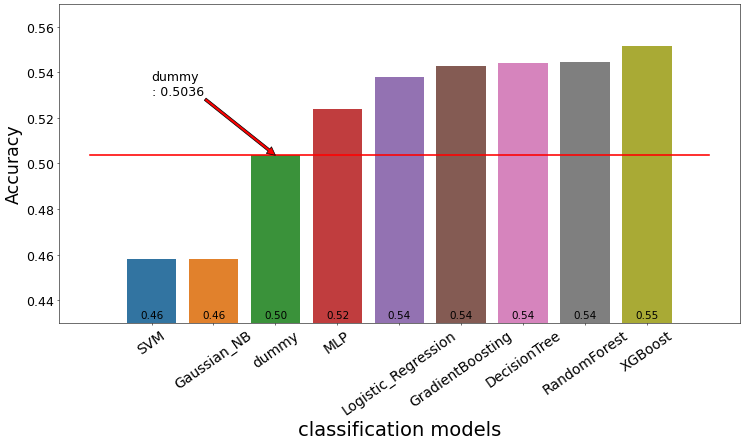

In [82]:
plt.figure(figsize=(15,9), dpi = 50)
# colors = sns.color_palette('hls',len(model_list))
g = sns.barplot(x = 'key', y = 'value', data=acc_df, capsize=.2) # , color = colors
_ = g.set_xticks(range(len(acc_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("classification models", fontsize = 28)
_ = g.set_ylabel("Accuracy", fontsize = 25)
_ = g.set_ylim([0.43, 0.57]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = acc_df[acc_df.key=='dummy']['value'].values
_ = g.plot([-1,len(acc_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (2, dummy_mean), xytext = (0, 0.53),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)

val = acc_df['value']
cnt = 0
for i in range(len(acc_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 0.432, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 0.432, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.432, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
# plt.savefig('[14w] -5 -1 acc_cla_plot.png')

[Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html?highlight=decisiontreeclassifier) <br>
[Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html?highlight=decisiontreeclassifier) <br>

## ROC AUC

<Figure size 750x450 with 0 Axes>

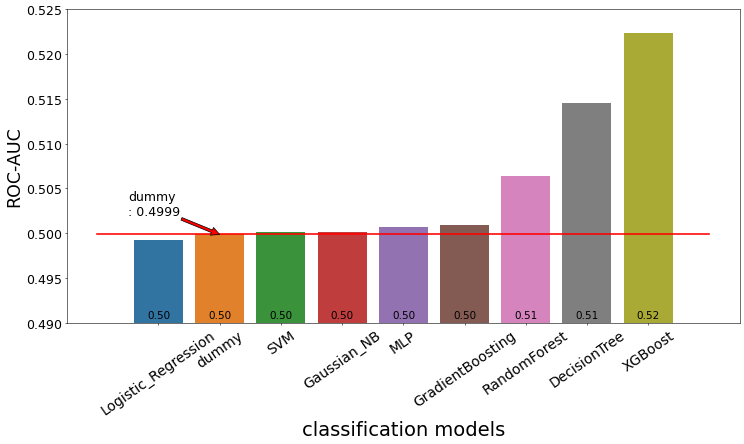

In [83]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=rocauc_df, capsize=.2)
_ = g.set_xticks(range(len(rocauc_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("classification models", fontsize = 28)
_ = g.set_ylabel("ROC-AUC", fontsize = 25)
_ = g.set_ylim([0.49, 0.525]) # g.set_ylim([0, 18]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = rocauc_df[rocauc_df.key=='dummy']['value'].values
_ = g.plot([-1,len(rocauc_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (1, dummy_mean), xytext = (-0.5, 0.502),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = rocauc_df['value']
cnt = 0
for i in range(len(rocauc_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 16.05, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 16.05, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.4905, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
# plt.savefig('[14w] -5 -2 rocauc_cla_plot.png')

## F1 score

<Figure size 750x450 with 0 Axes>

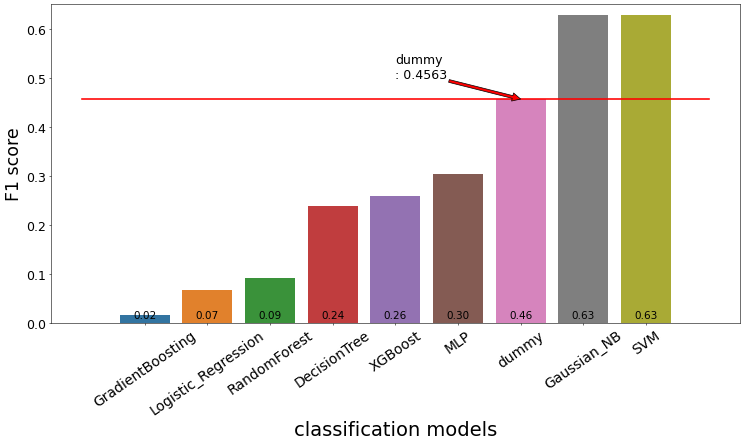

In [84]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=f1_df, capsize=.2)
_ = g.set_xticks(range(len(f1_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("classification models", fontsize = 28)
_ = g.set_ylabel("F1 score", fontsize = 25)
_ = g.set_ylim([0, 0.65]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = f1_df[f1_df.key=='dummy']['value'].values
_ = g.plot([-1,len(f1_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (6, dummy_mean), xytext = (4, 0.5),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = f1_df['value']
cnt = 0
for i in range(len(f1_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 16.05, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 16.05, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.01, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
# plt.savefig('[14w] -5 -3 f1_cla_plot.png')

# Jaccard index
희소데이터(데이터 값이 0이 많은 데이터)가 많은 경우에 사용함. <br>

[jaccard idex](https://medium.com/h-document/%EC%9E%90%EC%B9%B4%EB%93%9C-%EA%B1%B0%EB%A6%AC-jaccard-distance-e5b246603775)

<장점>
- 0이 많은 데이터에서는 해당 부분을 고려해줌

<단점>


<Figure size 750x450 with 0 Axes>

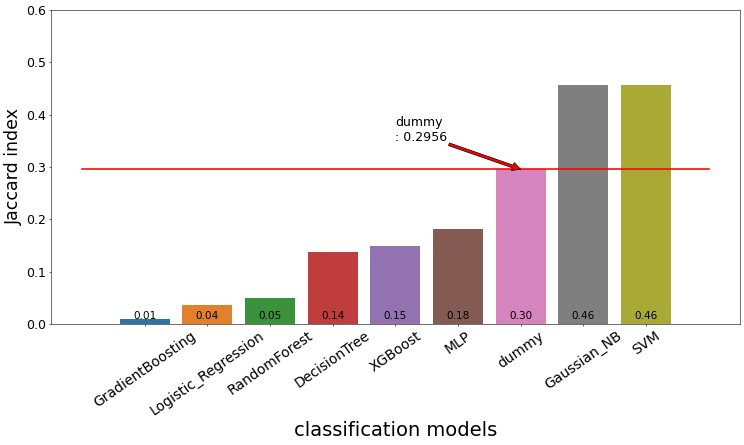

In [85]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=jaccard_df, capsize=.2)
_ = g.set_xticks(range(len(jaccard_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("classification models", fontsize = 28)
_ = g.set_ylabel("Jaccard index", fontsize = 25)
_ = g.set_ylim([0, 0.6]) # g.set_ylim([0, 18]) # ax.set(ylim=(0.4, 0.6))

dummy_mean = jaccard_df[jaccard_df.key=='dummy']['value'].values
_ = g.plot([-1,len(jaccard_df)], [dummy_mean, dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (6, dummy_mean), xytext = (4, 0.35),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = jaccard_df['value']
cnt = 0
for i in range(len(jaccard_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 16.05, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 16.05, tmp_fval, fontsize=15)
    else:
        _ = g.text(cnt-0.185, 0.01, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
# plt.savefig('[14w] -5 -4 jaccard_cla_plot.png')